In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression



In [3]:
df = pd.read_csv("full_year-may23-may24.csv", index_col="datetime")

Merge of the two csv datasets plus a new one, expanding from November 1st 2023 to August 1st 2023 - May 15 2024
Source: https://www.visualcrossing.com/weather/weather-data-services#

In [4]:
# city values remove extra spaces
df['name'] = df['name'].str.strip()
# calculate null value percentage in columns
null_pct = df.apply(pd.isnull).sum()/df.shape[0]
# use valid_columns as index of columns to keep which have less than 5% null values
valid_columns = df.columns[null_pct < .05]
df = df[valid_columns].copy()

In [5]:
df = df[['name', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'sunrise', 'sunset',
       'moonphase', 'conditions', 'description']]

In [6]:
df.rename(columns = {'name':'location'}, inplace = True)

In [7]:
df["location"].unique()

array(['Beijing', 'Berlin', 'London', 'Mexico City', 'Moscow', 'Ottawa',
       'Paris', 'Rome', 'Washington DC'], dtype=object)

In [8]:
# Function to perform linear regression and calculate R-squared
def linear_regression(df, location):
    X = df['dew']
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    y = df['temp']
    model = sm.OLS(y, X).fit()
    return model.rsquared

# Calculate R-squared for each city
r_squared_results = {}
for location in df['location'].unique():
    city_df = df[df['location'] == location]
    r_squared_results[location] = linear_regression(city_df, location)

# Print results
for location, r_squared in r_squared_results.items():
    print(f"{location}: R-squared: {r_squared:.2f}")

Beijing: R-squared: 0.81
Berlin: R-squared: 0.79
London: R-squared: 0.81
Mexico City: R-squared: 0.00
Moscow: R-squared: 0.91
Ottawa: R-squared: 0.91
Paris: R-squared: 0.80
Rome: R-squared: 0.81
Washington DC: R-squared: 0.87


In [9]:
df["location"].value_counts()

location
Beijing          381
Berlin           381
London           381
Mexico City      381
Moscow           381
Ottawa           381
Paris            381
Rome             381
Washington DC    381
Name: count, dtype: int64

In [10]:
beijing_city = df[df["location"] == "Beijing"]
berlin_city = df[df["location"] == "Berlin"]
London_city = df[df["location"] == "London"]
mexico_city = df[df["location"] == "Mexico City"]
moscow_city = df[df["location"] == "Moscow"]
ottawa_city = df[df["location"] == "Ottowa"]
paris_city = df[df["location"] == "Paris"]
rome_city = df[df["location"] == "Rome"]
washington_city = df[df["location"] == "Washington DC"]

In [11]:
# Function to perform linear regression and calculate R-squared
def linear_regression_single_location(loc_df, response='dew'):
    def inside_single_location(predictor):
        X = loc_df[predictor]
        X = sm.add_constant(X)  # Adds a constant term to the predictor
        y = loc_df[response]
        model = sm.OLS(y, X).fit()
        return model.rsquared

    r_squared_results = {}
    for predictor in loc_df.columns:
        if predictor not in ['location', 'dew']:
            try:
                r_squared = inside_single_location(predictor)
                r_squared_results[predictor] = r_squared
            except Exception as e:
                print(f"Error with predictor {predictor}: {e}")

    # Print results
    print(f"\nLocation: Mexico City for {response}")  # Replace with the actual location name
    for predictor, r_squared in sorted(r_squared_results.items(), key=lambda item: item[1], reverse=True):
        print(f" Predictor: {predictor}, R-squared: {r_squared:.2f}")



linear_regression_single_location(mexico_city)

Error with predictor sunrise: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).
Error with predictor sunset: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).
Error with predictor conditions: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).
Error with predictor description: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

Location: Mexico City for dew
 Predictor: humidity, R-squared: 0.70
 Predictor: precipprob, R-squared: 0.42
 Predictor: cloudcover, R-squared: 0.36
 Predictor: feelslikemin, R-squared: 0.27
 Predictor: precipcover, R-squared: 0.26
 Predictor: tempmin, R-squared: 0.26
 Predictor: precip, R-squared: 0.12
 Predictor: visibility, R-squared: 0.12
 Predictor: sealevelpressure, R-squared: 0.06
 Predictor: tempmax, R-squared: 0.06
 Predictor: feelslikemax, R-squared: 0.03
 Predictor: windspeed, R-squared: 0.01
 Predictor: windgust, R-squared: 

The workflow:
1) Understand the problem -- find next day's high/low temp; I have data on humidity, temperature, wind speed, etc
2) Identify Key Factors -- What are the independent variables (hint #1) and my dependent variables
3) Hypothesis -- _ significantly impacts 
4) Translate Hypo => Testable Statements -- Null/Alternate Hypothesis (this is an example, I had to do this in school, maybe it will help maybe not)
5) Design the Experiment -- Data collection/cleaning, model selection, evaluation metrics (Research here)
6) Analsys -- train the models, evaluate results (expected temp from your model vs actual temp), testing
7) Success 

- What determines the next day's high and low temperature for each location?
- What do you see from the data at first glance that might impact this?
- How would you need to organize and clean your data?
- Is your model 'universal', meaning does it apply to every location the same (no variance) when it comes to these predictions?
- If not, what factors impact your model?
- What tools or metrics will you need to use to account for these changes?
- Is your model accurate? What causes the inaccuracy, if any?

4) Translate Hypo => Testable Statements -- Null/Alternate Hypothesis (this is an example, I had to do this in school, maybe it will help maybe not)

5) Design the Experiment -- Data collection/cleaning, model selection, evaluation metrics (Research here)

- I used a heatmap to visualize the corralatioin between dew point and temperature

In [43]:
# Calculate the correlation for the entire dataset
corr, p_value = pearsonr(df['dew'], df['temp'])

# print(f'Pearson correlation coefficient: {corr}')
# print(f'P-value: {p_value}')

# Group data by location
grouped = df.groupby('location')

# Calculate correlation for each group
correlation_results = grouped.apply(lambda x: pearsonr(x['cloudcover'], x['tempmax'])[0])

/tmp/ipykernel_1715/1120353215.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_results = grouped.apply(lambda x: pearsonr(x['cloudcover'], x['tempmax'])[0])


Text(0.5, 1.0, 'Pearson Correlation between Dew Point and Temperature by Location')

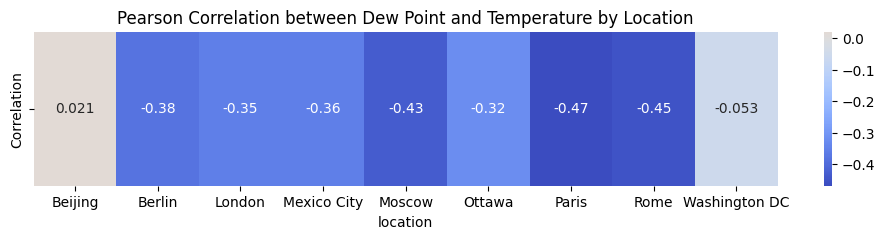

In [44]:
corr_df = pd.DataFrame(correlation_results, columns=['Correlation']).T

plt.figure(figsize=(12, 2))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0)
plt.title('Pearson Correlation between Dew Point and Temperature by Location')

- Check Regression assumptions
- Seperate dataframes per location
- R2 and Adjusted R2
- - sns.heatmap Pearson correlation test
- Feature selection
- Hypothesis -- significantly impacts
- Cross validation (Model selection)
- Training and evaluation

In [14]:
# r-squared for each variable
it = mexico_city[['tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility',
       'moonphase']]

target = 'tempmax'
features = it.columns.drop(target)
r_squared_values = {}

for feature in features:
    X = it[[feature]]
    y = it[target]

    model = LinearRegression()
    model.fit(X, y)

    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    r_squared_values[feature] = r2

# Convert the dictionary to a DataFrame for easier sorting
r_squared_df = pd.DataFrame(list(r_squared_values.items()), columns=['Feature', 'R-squared'])
r_squared_df = r_squared_df.sort_values(by='R-squared', ascending=False)

# Display the sorted DataFrame
print(f"\n{r_squared_df}")


             Feature  R-squared
2       feelslikemax   0.975279
1               temp   0.704478
4          feelslike   0.687455
6           humidity   0.398552
15  sealevelpressure   0.156866
17        visibility   0.132342
16        cloudcover   0.128278
0            tempmin   0.071125
3       feelslikemin   0.067030
5                dew   0.056871
12          windgust   0.041354
14           winddir   0.035761
13         windspeed   0.034036
9        precipcover   0.032837
8         precipprob   0.017106
7             precip   0.002361
18         moonphase   0.000186
11         snowdepth   0.000000
10              snow   0.000000


The true purpose of regression is to seperate the total variance in lowtemp and hightemp from the variance explained by dew and the variance that is still unexplained.

-0.01736241972031332


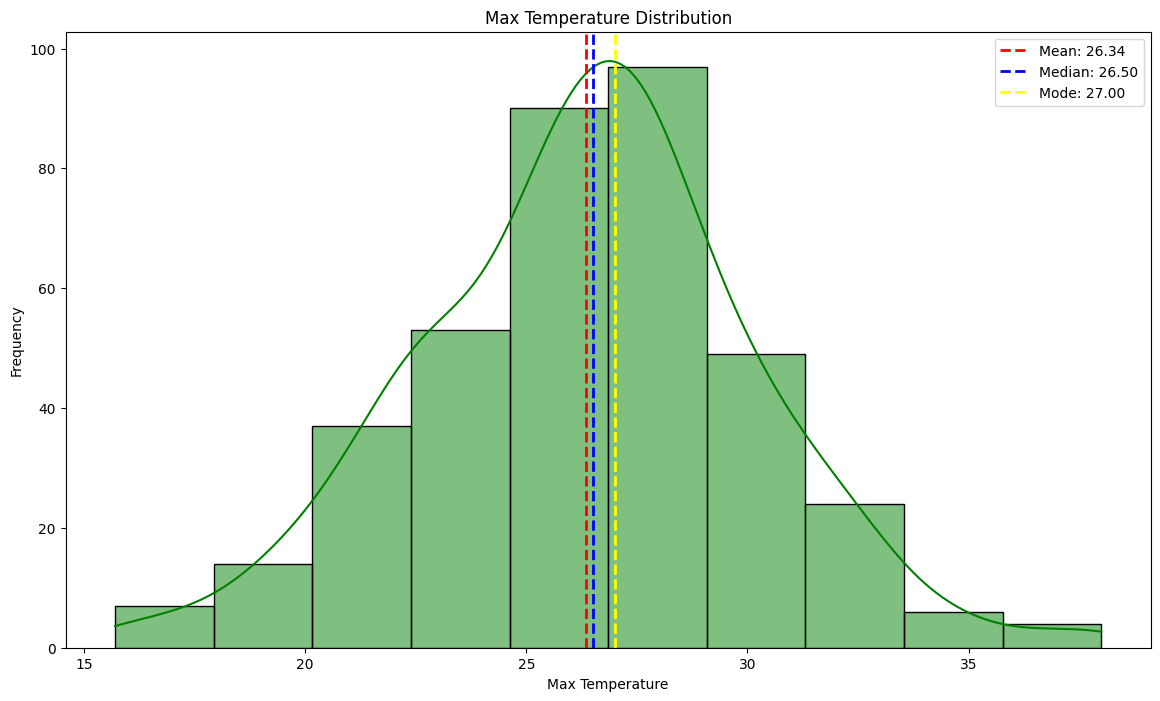

In [15]:
print(mexico_city["tempmax"].skew())

# Calculate statistics
mean_temp = mexico_city['tempmax'].mean()
median_temp = mexico_city['tempmax'].median()
mode_result = stats.mode(mexico_city['tempmax'], nan_policy='omit')

# Handling mode calculation
if isinstance(mode_result.mode, np.ndarray) and len(mode_result.mode) > 0:
    mode_temp = mode_result.mode[0]
else:
    mode_temp = mode_result.mode if mode_result.count > 0 else None

# Plot histogram and KDE
plt.figure(figsize=(14, 8))
sns.histplot(mexico_city['tempmax'], bins=10, kde=True, color='g', edgecolor='black', alpha=0.5)

# Plot mean, median, and mode lines
plt.axvline(mean_temp, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_temp:.2f}')
plt.axvline(median_temp, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_temp:.2f}')
plt.axvline(mode_temp, color='yellow', linestyle='dashed', linewidth=2, label=f'Mode: {mode_temp:.2f}')

# Add title and labels
plt.title('Max Temperature Distribution')
plt.xlabel('Max Temperature')
plt.ylabel('Frequency')
plt.legend()

In [35]:
df_numerical = df[['precip', 'precipprob', 'precipcover', 'snow', 'snowdepth',
       'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'moonphase']]

In [42]:
# Assuming 'it' is your DataFrame with columns humidity, dew, and tempmax
# Function to calculate adjusted R-squared
def adjusted_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# For humidity
X_humidity = it[['humidity', 'feelslikemax', 'dew']]  # Features (independent variables)
y = it['tempmax']  # Target variable (dependent variable)

# Initialize and fit the linear regression model
model_humidity = LinearRegression()
model_humidity.fit(X_humidity, y)

# Predictions and R-squared for humidity
y_pred_humidity = model_humidity.predict(X_humidity)
r2_humidity = r2_score(y, y_pred_humidity)
n_humidity = X_humidity.shape[0]  # Number of samples
p_humidity = X_humidity.shape[1]  # Number of features
adj_r2_humidity = adjusted_r2(r2_humidity, n_humidity, p_humidity)

print(f"R-squared (humidity to tempmax): {r2_humidity}")
print(f"Adjusted R-squared (humidity to tempmax): {adj_r2_humidity}")

R-squared (humidity to tempmax): 0.9849652282460464
Adjusted R-squared (humidity to tempmax): 0.9848455881525136


In [40]:
# Define features and target
X = it.drop(['precip', 'precipprob', 'precipcover', 'snow', 'snowdepth',
            'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
            'moonphase'], axis=1)
y = it['tempmax']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define models
ridge = Ridge()

# Define parameter grids for hyperparameter tuning
param_grid_ridge = {'alpha': np.logspace(-4, 4, 50)}

# Perform grid search with cross-validation
grid_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='r2')

# Fit models
grid_ridge.fit(X_train, y_train)

# Evaluate models on test set
models = {'Ridge': grid_ridge}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"{name} R-squared: {r2_score(y_test, y_pred)}")
    print(f"{name} MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"Best Parameters for {name}: {model.best_params_}")

Ridge R-squared: 0.9999999999800697
Ridge MSE: 2.2715007756797315e-10
Best Parameters for Ridge: {'alpha': 0.0001}


ElasticNet R-squared: 0.9999999993541295
ElasticNet MSE: 7.361149261789576e-09
Best Parameters for ElasticNet: {'alpha': 0.0001, 'l1_ratio': 1.0}

Lasso R-squared: 0.9999999993541295
Lasso MSE: 7.361149261789576e-09
Best Parameters for Lasso: {'alpha': 0.0001}

Ridge R-squared: 0.9999999999999003
Ridge MSE: 1.1364757457790597e-12
Best Parameters for Ridge: {'alpha': 0.0001}

In [37]:
# Define new features and target
features = ['precip', 'precipprob', 'precipcover', 'snow', 'snowdepth',
            'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
            'moonphase']
X = it[features]
y = it['tempmax']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=features)

# Add the target variable to the DataFrame
data = pd.concat([X, y.reset_index(drop=True)], axis=1)

# Split the data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Fit nested models using statsmodels for ANOVA
model1 = ols('tempmax ~ precip', data=train_data).fit()
model2 = ols('tempmax ~ precip + precipprob', data=train_data).fit()
model3 = ols('tempmax ~ precip + precipprob + precipcover', data=train_data).fit()
model4 = ols('tempmax ~ precip + precipprob + precipcover + snow', data=train_data).fit()
model5 = ols('tempmax ~ precip + precipprob + precipcover + snow + snowdepth', data=train_data).fit()
model6 = ols('tempmax ~ precip + precipprob + precipcover + snow + snowdepth + windgust', data=train_data).fit()
model7 = ols('tempmax ~ precip + precipprob + precipcover + snow + snowdepth + windgust + windspeed', data=train_data).fit()
model8 = ols('tempmax ~ precip + precipprob + precipcover + snow + snowdepth + windgust + windspeed + winddir', data=train_data).fit()
model9 = ols('tempmax ~ precip + precipprob + precipcover + snow + snowdepth + windgust + windspeed + winddir + sealevelpressure', data=train_data).fit()
model10 = ols('tempmax ~ precip + precipprob + precipcover + snow + snowdepth + windgust + windspeed + winddir + sealevelpressure + cloudcover', data=train_data).fit()
model11 = ols('tempmax ~ precip + precipprob + precipcover + snow + snowdepth + windgust + windspeed + winddir + sealevelpressure + cloudcover + visibility', data=train_data).fit()
model12 = ols('tempmax ~ precip + precipprob + precipcover + snow + snowdepth + windgust + windspeed + winddir + sealevelpressure + cloudcover + visibility + moonphase', data=train_data).fit()

# Perform ANOVA
anova_results = sm.stats.anova_lm(model1, model2, model3, model4, model5, model6, model7, model8, model9, model10, model11, model12)
print(anova_results)


    df_resid          ssr  df_diff       ss_diff          F        Pr(>F)
0      302.0  4541.890522      0.0           NaN        NaN           NaN
1      301.0  4474.460545      1.0  6.742998e+01   6.868503  9.218189e-03
2      300.0  4374.746110      1.0  9.971443e+01  10.157038  1.589135e-03
3      300.0  4374.746110     -0.0 -9.094947e-13        inf           NaN
4      300.0  4374.746110     -0.0 -0.000000e+00        NaN           NaN
5      299.0  4173.500110      1.0  2.012460e+02  20.499171  8.624956e-06
6      298.0  4068.900350      1.0  1.045998e+02  10.654664  1.225755e-03
7      297.0  3910.738844      1.0  1.581615e+02  16.110530  7.571088e-05
8      296.0  3426.880632      1.0  4.838582e+02  49.286408  1.516738e-11
9      295.0  3217.391002      1.0  2.094896e+02  21.338878  5.755838e-06
10     294.0  2909.253201      1.0  3.081378e+02  31.387305  4.859453e-08
11     293.0  2876.461532      1.0  3.279167e+01   3.340201  6.862328e-02


In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_numerical.assign(constant=1)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

             feature           VIF
0             precip      1.356313
1         precipprob      1.857855
2        precipcover      2.300363
3               snow      1.150798
4          snowdepth      1.121873
5           windgust      1.880324
6          windspeed      1.733378
7            winddir      1.052069
8   sealevelpressure      1.334987
9         cloudcover      1.515251
10        visibility      1.066328
11         moonphase      1.001982
12          constant  16591.870025
